# Traffic Sign Detection with Faster RCNN

## Imports, setup etc.

In [6]:
# System
import os
import time
from IPython.display import clear_output
from tqdm.auto import tqdm

# Standard libs
import numpy as np
import pandas as pd
import random

# Plotting
import matplotlib.pyplot as plt

# Image utils
from PIL import Image
import cv2
from glob import glob

# PyTorch 
import torch
import torchvision
import torch.nn.functional as F
import torchvision.datasets
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision.io import read_image
from torchvision.datasets import DatasetFolder
from torchvision.datasets.folder import default_loader

In [7]:
!pip -q install httpimport
!pip -q install pycocotools
import httpimport

In [10]:
with httpimport.github_repo(
     "dmika1234", "dl_uwr", "project"
):
     import Project.all_coco_utils as coco_utils

In [11]:
DATA_PATH = '/kaggle/input/german-traffic-sign-detection-benchmark-gtsdb'
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'TrainIJCNN2013/TrainIJCNN2013')
TEST_DATA_PATH = os.path.join(DATA_PATH, 'TestIJCNN2013/TestIJCNN2013Download')

## Data preparation

### Moving training images into one directory, creating new annotation file

In [ ]:
current_train_dir = TRAIN_DATA_PATH
new_train_dir = os.path.join(os.getcwd(), 'Train/images')
os.makedirs(new_train_dir, exist_ok=True)


file_names_in = []
for root, dirs, files in os.walk(current_train_dir):
    print(files)
    for file in files:
#         print(file)
        if file.endswith(".ppm") and file not in file_names_in:
            # Open the .ppm image
            img = Image.open(os.path.join(root, file))
            # Convert the image to .jpg
            # rgb_im = img.convert('RGB')
            # Save the .jpg image to the new directory
            img.save(os.path.join(new_train_dir, file))
            file_names_in.append(file)

# gt2 = pd.read_csv(os.path.join(DATA_PATH, 'gt.txt'), delimiter=";", header=None)
# gt2.iloc[:,0] = gt2.iloc[:,0].str[:-4] + '.jpg'
# gt2.to_csv(os.path.join(os.getcwd(), 'gt_jpg.txt'), sep=";", header=None, index=False)

TRAIN_DATA_PATH = 'Train'

In [44]:
pt = glob('/kaggle/input/german-traffic-sign-detection-benchmark-gtsdb/TrainIJCNN2013/TrainIJCNN2013/*.ppm')
current_train_dir = TRAIN_DATA_PATH
new_train_dir = os.path.join(os.getcwd(), 'Train/images')
os.makedirs(new_train_dir, exist_ok=True)


file_names_in = []
for file in pt:
    if file.endswith(".ppm") and file not in file_names_in:
        # Open the .ppm image
        img = Image.open(file)
        # Convert the image to .jpg
        # rgb_im = img.convert('RGB')
        # Save the .jpg image to the new directory
        img.save(os.path.join(new_train_dir, os.path.basename(file)))
        file_names_in.append(os.path.basename(file))

# gt2 = pd.read_csv(os.path.join(DATA_PATH, 'gt.txt'), delimiter=";", header=None)
# gt2.iloc[:,0] = gt2.iloc[:,0].str[:-4] + '.jpg'
# gt2.to_csv(os.path.join(os.getcwd(), 'gt_jpg.txt'), sep=";", header=None, index=False)

TRAIN_DATA_PATH = 'Train/images'

In [36]:
txt = np.genfromtxt(os.path.join(DATA_PATH, 'gt.txt'),delimiter =';', dtype= None,encoding=None)

#Creating a dictionary with image names as key and annotations as value
dic ={}
for i in range (0,len(txt)):
    #Image name is first element of annotation file
    img_name = txt[i][0]
    # 4 Coordinates
    target = [txt[i][1],txt[i][2],txt[i][3],txt[i][4],txt[i][5]]
    #Last element is the class number
    clas = txt[i][-1]
    #If multiple objects, store coordinates and classes as list of lists
    if(img_name in dic):
        dic[img_name].append(target)
    else:
        dic[img_name] = [target]
print(dic['00001.ppm'])
print("Number of Images: " + str(len(dic)))

[[983, 388, 1024, 432, 40], [386, 494, 442, 552, 38], [973, 335, 1031, 390, 13]]
Number of Images: 506


In [45]:
# os.makedirs('Train/imagesf')
# file_names_in

In [46]:
#Copy only files that are annotated in the gt.txt to imagesf
import shutil

pt = glob('Train/images/*.ppm')

len(pt)
#Copying into new directory
for i in range(len(dic)):
    ofile = r'Train/images/{}'.format(list(dic)[i])
    target = r'Train/imagesf/{}'.format(list(dic)[i])
    shutil.copyfile(ofile, target)
#Check if len(dic) == number of images in folder
print(len(glob('Train/imagesf/*.ppm')))
len(dic)

506


506

### Defining custom dataset
 - img_dir: images directory
 - annotations_file: file with labels, bounding boxes, file names
 - transorms: transforms

In [52]:
# class TrafficSignsDatasetRCNN(Dataset):
#     def __init__(self, img_dir, annotations_file, transforms=None):
#         self.img_dir = img_dir
#         self.transforms = transforms
#         self.annotations = pd.read_csv(annotations_file, sep=";", header=None,
#                                     names=["filename", "x1", "y1", "x2", "y2", "class"])
#         self.imgs = list(sorted(os.listdir(img_dir)))
 
#     def __getitem__(self, idx):
#         # Load image path
#         img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
#         #Load image as PIL
#         img = Image.open(img_path).convert("RGB")        
#         # Get objects
#         objects = self.annotations[self.annotations.filename == self.annotations.iloc[idx, 0]]
#         # Get bounding box coordinates for each object in image
#         boxes = []
#         labels = []
#         # fetch all the bounding boxes and labels for the current image
#         for _, row in objects.iterrows():
#             boxes.append([row["x1"], row["y1"], row["x2"], row["y2"]])
#             labels.append(row["class"])

#         boxes = torch.as_tensor(boxes, dtype=torch.float32)
#         labels = torch.as_tensor(labels, dtype=torch.int64)        
 
#         image_id = torch.tensor([idx])
#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         # suppose all instances are not crowd
#         iscrowd = torch.zeros((len(objects),), dtype=torch.int64)
 
#         target = {}
#         target["boxes"] = boxes
#         target["labels"] = labels
#         target["image_id"] = image_id
#         target["area"] = area
#         target["iscrowd"] = iscrowd
 
#         if self.transforms is not None:
#             # Note that target (including bbox) is also transformed\enhanced here, which is different from transforms from torchvision import
#             # Https://github.com/pytorch/vision/tree/master/references/detectionOfTransforms.pyThere are examples of target transformations when RandomHorizontalFlip
#             img, target = self.transforms(img, target)
 
#         return img, target
 
#     def __len__(self):
#         return len(self.imgs)
    
class TrafficSignsDatasetRCNN(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "imagesf"))))
 
    def __getitem__(self, idx):
        # Load image path
        img_path = os.path.join(self.root, "imagesf", self.imgs[idx])
        #Load image as PIL
        img = Image.open(img_path).convert("RGB")        
        # Get objects in the image
        objects = dic[self.imgs[idx]]
        # Get bounding box coordinates for each object in image
        boxes = []
        labels = []
        for obj in objects:
            #print(idx, obj[-1], self.imgs)
            name = obj[-1]
            labels.append(int(name))
            #Get bounding box coordinates
            xmin = float(obj[0])
            ymin = float(obj[1])
            xmax = float(obj[2])
            ymax = float(obj[3])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)        
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((len(objects),), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            # Note that target (including bbox) is also transformed\enhanced here, which is different from transforms from torchvision import
            # Https://github.com/pytorch/vision/tree/master/references/detectionOfTransforms.pyThere are examples of target transformations when RandomHorizontalFlip
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [53]:
# Sample init

dt = TrafficSignsDatasetRCNN('Train')
loader = iter(dt)
next(loader)

(<PIL.Image.Image image mode=RGB size=1360x800>,
 {'boxes': tensor([[774., 411., 815., 446.]]),
  'labels': tensor([11]),
  'image_id': tensor([0]),
  'area': tensor([1435.]),
  'iscrowd': tensor([0])})

### Data Augmentation using PyTorch's Transforms

In [54]:
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(coco_utils.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        # 50% chance of flipping horizontally
        transforms.append(coco_utils.RandomHorizontalFlip(0.5))
 
    return coco_utils.T_Compose(transforms)

## Training the Model

### Creating loaders, model, optimizer

In [55]:
# from engine import train_one_epoch, evaluate
# import utilss
import torch.nn as nn
# os.environ['TORCH_HOME'] = './'
root = r'Train'

# Train on the GPU if available else CPU.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 44 classes = 43 + background
num_classes = 44
#Send the data to the myDataset class (Apply transformations, Get bbox, labels, objects)
dataset = TrafficSignsDatasetRCNN(root, get_transform(train=True))
dataset_test = TrafficSignsDatasetRCNN(root, get_transform(train=False))

# split the dataset in train and test set
# My dataset has 506 images, almost training validation 4:1
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# define training and validation data loaders
#collate_fn returns tuples of images and image annotations for every iteration.
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, # num_workers=4,
    collate_fn=coco_utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=2, shuffle=False, # num_workers=4,
    collate_fn=coco_utils.collate_fn)

# Define model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False, progress=True, num_classes=num_classes, pretrained_backbone=True)

# Move the model to device
model.to(device)

print("Model loaded")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

Model loaded


### Starting the Training

In [56]:
# Constructing the optimizer
params = [p for p in model.parameters() if p.requires_grad]

# SGD
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2)

# Training for no. of Epochs
num_epochs = 100


losses = []
loss_box_reg = []
loss_rpn_box_reg = []
loss_classifier = []
loss_objectness = []

stat0 = []
stat1 = []
stat2 = []
stat3 = []
stat4 = []
stat5 = []
stat6 = []
stat7 = []
stat8 = []
stat9 = []
stat10 = []
stat11 = []


for epoch in range(num_epochs):
    # Engine.py's train_one_epoch function takes both images and targets. to(device)
    # Metrics (metric_logger) was returned by train_one_epoch() in engine.py to get losses
    metrics = coco_utils.train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    losses.append(float(str(metrics.meters['loss']).split(" ")[0]))
    loss_box_reg.append(float(str(metrics.meters['loss_box_reg']).split(" ")[0]))
    loss_rpn_box_reg.append(float(str(metrics.meters['loss_rpn_box_reg']).split(" ")[0]))
    loss_classifier.append(float(str(metrics.meters['loss_classifier']).split(" ")[0]))
    loss_objectness.append(float(str(metrics.meters['loss_objectness']).split(" ")[0]))
    
    # Update the learning rate
    lr_scheduler.step()

    # Evaluate on the test dataset
    # _ gives coco_evaL obj from coco_eval.py from CocoEvaluator()
    _, metric_logger = coco_utils.coco_evaluate(model, data_loader_test, device=device)
    #Stat object is from pycocotools' self.stats in summarize()
    #https://github.com/cocodataset/cocoapi/blob/master/PythonAPI/pycocotools/cocoeval.py
    stat = _.coco_eval['bbox'].stats
    
    #Append all stats
    stat0.append(stat[0])
    stat1.append(stat[1])
    stat2.append(stat[2])
    stat3.append(stat[3])
    stat4.append(stat[4])
    stat5.append(stat[5])
    stat6.append(stat[6])
    stat7.append(stat[7])
    stat8.append(stat[8])
    stat9.append(stat[9])
    stat10.append(stat[10])
    stat11.append(stat[11])
    
    
    print('')
    print('==================================================')
    print('')

print("Done!")

Epoch: [0]  [  0/203]  eta: 0:39:17  lr: 0.000003  loss: 4.3947 (4.3947)  loss_classifier: 3.6933 (3.6933)  loss_box_reg: 0.0068 (0.0068)  loss_objectness: 0.6915 (0.6915)  loss_rpn_box_reg: 0.0031 (0.0031)  time: 11.6124  data: 0.0573  max mem: 2597
Epoch: [0]  [ 50/203]  eta: 0:02:00  lr: 0.000127  loss: 2.0440 (3.3973)  loss_classifier: 1.3390 (2.6865)  loss_box_reg: 0.0074 (0.0133)  loss_objectness: 0.6745 (0.6792)  loss_rpn_box_reg: 0.0143 (0.0184)  time: 0.5707  data: 0.0263  max mem: 2753
Epoch: [0]  [100/203]  eta: 0:01:10  lr: 0.000250  loss: 0.4009 (1.9492)  loss_classifier: 0.2045 (1.4532)  loss_box_reg: 0.0812 (0.0319)  loss_objectness: 0.1049 (0.4447)  loss_rpn_box_reg: 0.0092 (0.0194)  time: 0.5862  data: 0.0261  max mem: 2754
Epoch: [0]  [150/203]  eta: 0:00:34  lr: 0.000374  loss: 0.4705 (1.4592)  loss_classifier: 0.2534 (1.0580)  loss_box_reg: 0.1323 (0.0635)  loss_objectness: 0.0572 (0.3202)  loss_rpn_box_reg: 0.0138 (0.0175)  time: 0.6037  data: 0.0293  max mem: 2754

KeyboardInterrupt: 

<a id='plots'></a>

### 3) Evaluation

#### Plotting the Stats

All the metrics from COCO Evaluation are recorded and plotted below.
<br>
To understand them, refer to [COCO's Detection Evaluation](https://cocodataset.org/#detection-eval). </br>

True Positive (TP): When the IoU over predicted bounding box and ground truth is greater than or equal to the threshold.
False Positive (FP): When the IoU over predicted bounding box and ground truth is less than threshold.


Average Precision ($AP$) is the number of true positives in the resulting bounding boxes.
Average Recall ($AR$) is the proportion of true positives out of possible positives.


COCO Evaluation mentions that they make no distinction between AP and mAP, AR and mAP. The AP and AR are averaged over multiple IoU values. They have used 10 IoU thresholds of .50:.05:.95 (start from 0.5 to 0.95 with a step size of 0.05) instead of computing over a single IoU of .50. Averaging ensures better localization.

The size of objects (area = small, medium, large) is mesasured in number of pixels.



The following can be inferred from the stats of the last iteration:
1. The AP @ IoU=0.5:0.95 for area = large is 0.800 which means that when the model detects an object with large area, 80% of the time it matches the ground truth objects.

2. The AR @IoU=0.5:0.95 for area = large is 0.800 which means that the model detects 80% of objects with large area, correctly.

3. For area = medium and small, the model does not do well. This was probably caused by the small size of dataset and the insufficient number of examples for small and medium sized objects.

The following can be inferred from the loss plots:

1. $Loss Box Reg$ is the measure of how tightly the model predicted the bounding box around the true object. It can be observed that the model works well to fit the bbox tightly to the object.

2. $Loss RPN Box Reg$ measures the performance of network for retrieving the region proposals. The plot shows that further training or tweaking the hyperparameters may be required to decrease the loss. This may require more data to improve the results significantly.

3. $Loss Classifier$ measures the performance of the object classification for detected bounding boxes. The plot shows that the model performs well in classifying the objects in the detected bounding boxes.

4. $Loss Objectness$ measures the performance of network for retrieving bounding boxes which contain an object. We can infer that the model is detecting the object very well.

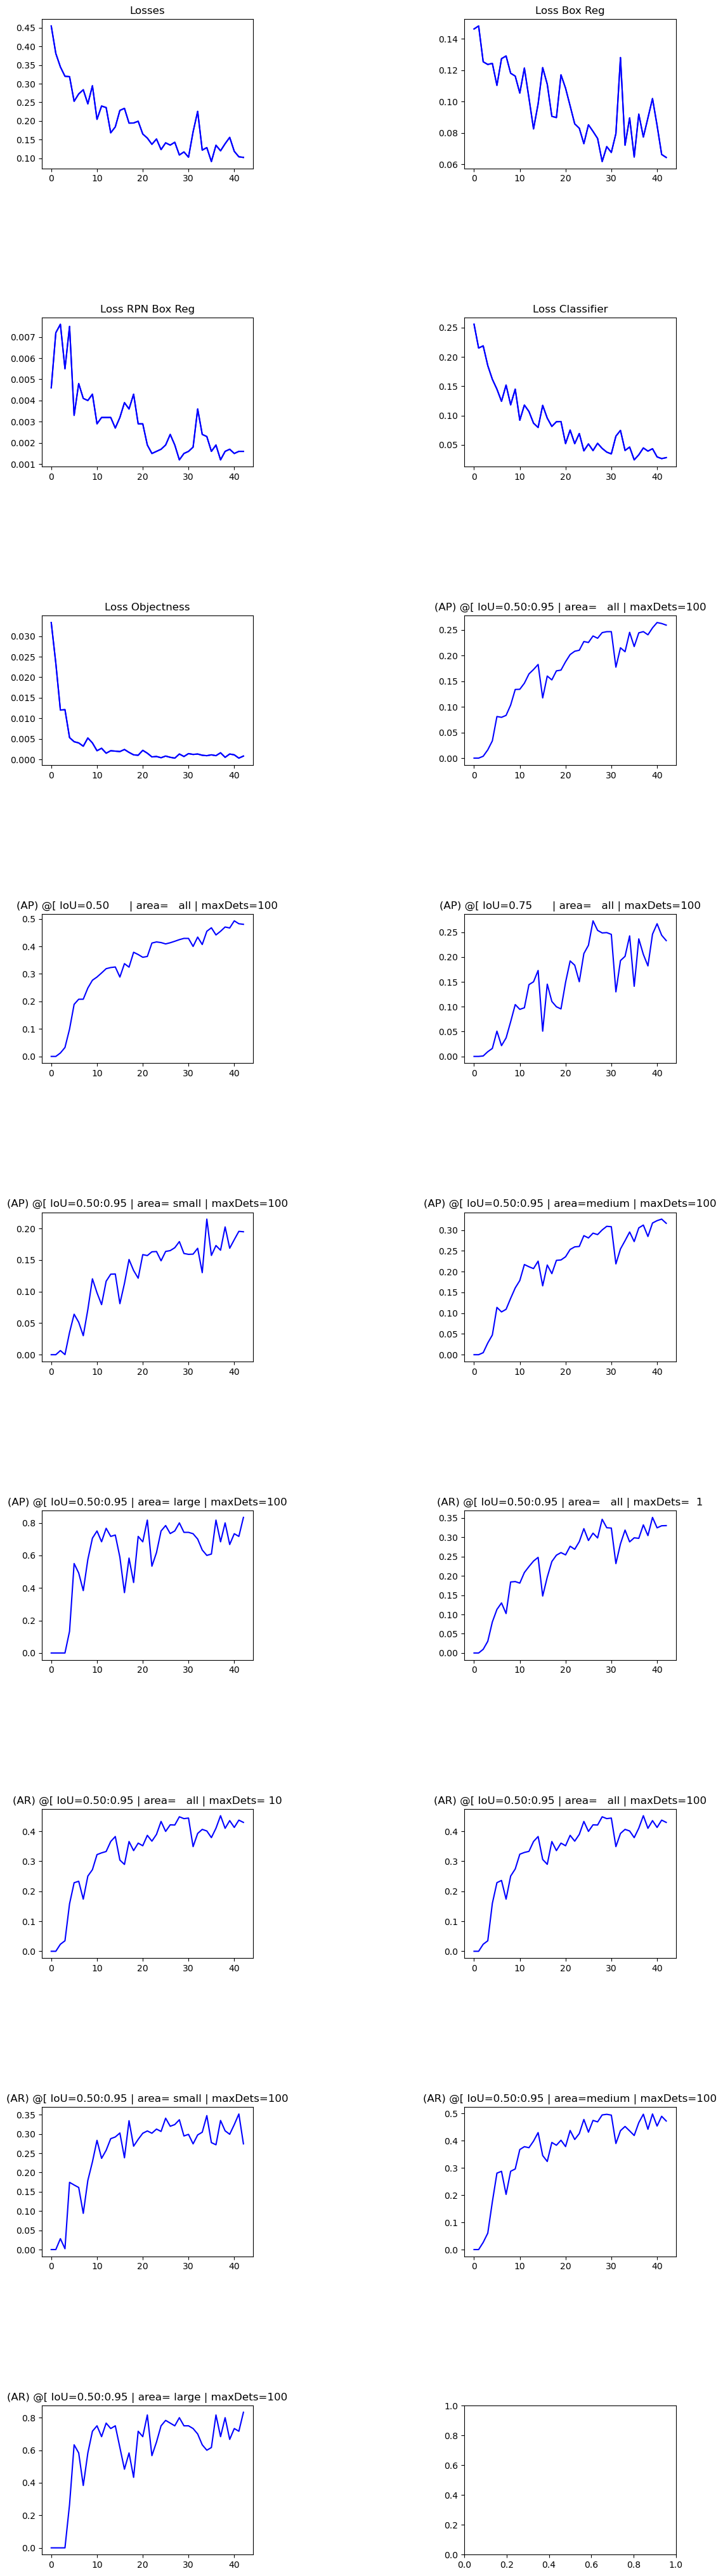

In [58]:
r,c = 9,2
fig, ax = plt.subplots(nrows=r, ncols=c)
fig.set_figheight(40)
fig.set_figwidth(10)
fig.subplots_adjust(left=14,right=15, top=6, bottom=5, hspace=1, wspace=1)


ax1 = plt.subplot(r, c, 1)
ax1.set_title("Losses")
ax2 = plt.subplot(r, c, 2)
ax2.set_title("Loss Box Reg")
ax3 = plt.subplot(r, c, 3)
ax3.set_title("Loss RPN Box Reg")
ax4 = plt.subplot(r, c, 4)
ax4.set_title("Loss Classifier")
ax5 = plt.subplot(r, c, 5)
ax5.set_title("Loss Objectness")
ax6 = plt.subplot(r, c, 6)
ax6.set_title("(AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100")
ax7 = plt.subplot(r, c, 7)
ax7.set_title("(AP) @[ IoU=0.50      | area=   all | maxDets=100")
ax8 = plt.subplot(r, c, 8)
ax8.set_title("(AP) @[ IoU=0.75      | area=   all | maxDets=100")
ax9 = plt.subplot(r, c, 9)
ax9.set_title("(AP) @[ IoU=0.50:0.95 | area= small | maxDets=100")
ax10 = plt.subplot(r, c, 10)
ax10.set_title("(AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100")
ax11 = plt.subplot(r, c, 11)
ax11.set_title("(AP) @[ IoU=0.50:0.95 | area= large | maxDets=100")
ax12 = plt.subplot(r, c, 12)
ax12.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1")
ax13 = plt.subplot(r, c, 13)
ax13.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10")
ax14 = plt.subplot(r, c, 14)
ax14.set_title("(AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100")
ax15 = plt.subplot(r, c, 15)
ax15.set_title("(AR) @[ IoU=0.50:0.95 | area= small | maxDets=100")
ax16 = plt.subplot(r, c, 16)
ax16.set_title("(AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100")
ax17 = plt.subplot(r, c, 17)
ax17.set_title("(AR) @[ IoU=0.50:0.95 | area= large | maxDets=100")

ax1.plot(losses, 'b')
ax2.plot(loss_box_reg, 'b')
ax3.plot(loss_rpn_box_reg, 'b')
ax4.plot(loss_classifier, 'b')
ax5.plot(loss_objectness, 'b')
ax1.plot(losses, 'b')
ax2.plot(loss_box_reg, 'b')
ax3.plot(loss_rpn_box_reg, 'b')
ax4.plot(loss_classifier, 'b')
ax5.plot(loss_objectness, 'b')
ax6.plot(stat0, 'b')
ax7.plot(stat1, 'b')
ax8.plot(stat2, 'b')
ax9.plot(stat3, 'b')
ax10.plot(stat4, 'b')
ax11.plot(stat5, 'b')
ax12.plot(stat6, 'b')
ax13.plot(stat7, 'b')
ax14.plot(stat8, 'b')
ax15.plot(stat9, 'b')
ax16.plot(stat10, 'b')
ax17.plot(stat11, 'b')
plt.show()

#### Drawing the bounding box for a prediction

The code below obtains the predictions made by the model in the format of a dictionary of boxes, labels and scores.

##### Non maximum suppression:
A number of proposals can be made by the model for the same object. We can filter the unwanted boxes by using Non-maximum suppression. Torchvision's library was used to perform NMS.

Next, the Image is converted to the a numpy array from tensor format and then to the RGB format.
A dictionary of class ID as keys and values as their string name is declared to display on the image.

Finally, for every bounding box, a rectangle box and class text is displayed in the predicted image. 

In [59]:
def showbbox(model, img):
    # The img entered is a tensor in the 0-1 range        
    model.eval()
    with torch.no_grad():
        '''
        prediction Like:
        [{'boxes': tensor([[1221.7869,  523.7036, 1272.7373,  575.1018],
        [ 192.8189,  527.5751,  240.7135,  589.8405],
        [ 197.3745,  538.7914,  235.9153,  572.1550],
        [ 195.1216,  533.9565,  238.6585,  578.0548],
        [ 194.0861,  517.0943,  238.0777,  582.4178]], device='cuda:0'), 
        'labels': tensor([7, 7, 7, 8, 5], device='cuda:0'), 
        'scores': tensor([0.9792, 0.9036, 0.2619, 0.2407, 0.0575], device='cuda:0')}]
        '''
        prediction = model([img.to(device)])

    print(prediction)
    b = prediction[0]['boxes']
    #print(b)
    s = prediction[0]['scores']
    #print(s)
    
    #Apply Non-maximum suppression:
    keep = torchvision.ops.nms(b,s,0.1)
    #print(keep)
        
    img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
    img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
    img = np.array(img)  # tensor → ndarray
    #Convert np array img to right format.
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #Class number coressponding to Classes
    classes = { 0:' Speed limit (20km/h)' ,
    1:' Speed limit (30km/h)' ,
    2:' Speed limit (50km/h)' ,
    3:' Speed limit (60km/h)' ,
    4:' Speed limit (70km/h)' ,
    5:' Speed limit (80km/h)' ,
    6:' End of speed limit (80km/h)' ,
    7:' Speed limit (100km/h)' ,
    8:' Speed limit (120km/h)' ,
    9:' No passing' ,
    10:' No passing veh over 3.5 tons' ,
    11:' Right-of-way at intersection' ,
    12:' Priority road' ,
    13:' Yield' ,
    14:' Stop' ,
    15:' No vehicles' ,
    16:' Veh > 3.5 tons prohibited' ,
    17:' No entry' ,
    18:' General caution' ,
    19:' Dangerous curve left' ,
    20:' Dangerous curve right' ,
    21:' Double curve' ,
    22:' Bumpy road' ,
    23:' Slippery road' ,
    24:' Road narrows on the right' ,
    25:' Road work' ,
    26:' Traffic signals' ,
    27:' Pedestrians' ,
    28:' Children crossing' ,
    29:' Bicycles crossing' ,
    30:' Beware of ice/snow' ,
    31:' Wild animals crossing' ,
    32:' End speed + passing limits' ,
    33:' Turn right ahead' ,
    34:' Turn left ahead' ,
    35:' Ahead only' ,
    36:' Go straight or right' ,
    37:' Go straight or left' ,
    38:' Keep right' ,
    39:' Keep left' ,
    40:' Roundabout mandatory' ,
    41:' End of no passing' ,
    42:' End no passing veh > 3.5 tons'  }
    
    
    for k in range(len(keep)):
        xmin = round(prediction[0]['boxes'][k][0].item())
        ymin = round(prediction[0]['boxes'][k][1].item())
        xmax = round(prediction[0]['boxes'][k][2].item())
        ymax = round(prediction[0]['boxes'][k][3].item())
        
        label = prediction[0]['labels'][k].item()
        print("Label is: {}\n===\n(Xmin, Ymin, Xmax, Ymax) = ({}, {}, {}, {}) \n===".format(label, xmin, ymin, xmax, ymax))
        
        #color = list(np.random.random(size=3)*256)
        colors = np.random.uniform(0, 255, size=(43, 3))
        
        if label in classes:
            pt1 = (xmin, ymin)
            pt2 = (xmax, ymax)
            print("Class Label: "+ classes[label])
            score = prediction[0]['scores'][k].item()
            print("Score: "+ str(score))
            print("\n===============\n")
            color = list(colors[label])
            cv2.rectangle(img, pt1, pt2, color, thickness=2)
            cv2.putText(img, classes[label]+"-"+str(round(score,2)), (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color,
                        thickness=2)

    plt.figure(figsize=(40,35))
    plt.imshow(img)

print("Function Loaded")

Function Loaded


#### Testing the Model

[{'boxes': tensor([[697.0652, 433.3929, 725.0910, 462.6064],
        [692.1139, 450.3730, 723.8817, 484.6145],
        [701.6869, 440.0255, 723.1996, 459.0430],
        [699.1971, 456.9923, 722.3738, 480.4317],
        [698.9554, 458.0761, 720.3887, 479.7625],
        [696.1332, 458.8473, 722.1154, 481.7155],
        [700.1523, 436.7632, 722.3898, 465.5612],
        [685.1384, 431.5959, 731.5081, 467.0546],
        [695.3939, 436.0305, 725.4374, 462.1215],
        [687.7578, 444.7419, 731.6353, 459.7005],
        [692.8848, 454.2086, 725.5451, 484.5544],
        [698.2502, 423.1055, 724.2473, 475.1986],
        [691.9808, 447.7509, 722.9526, 482.7600],
        [687.7132, 446.1823, 731.3663, 460.9686],
        [683.7719, 444.2645, 735.3610, 460.5780],
        [699.6500, 456.4246, 719.4482, 483.3067],
        [701.0424, 431.0091, 723.5735, 450.1155],
        [689.7743, 449.3997, 727.1203, 467.0409]], device='cuda:0'), 'labels': tensor([20,  3, 20,  3,  4,  2, 22, 26, 26, 20,  4, 22,  8, 

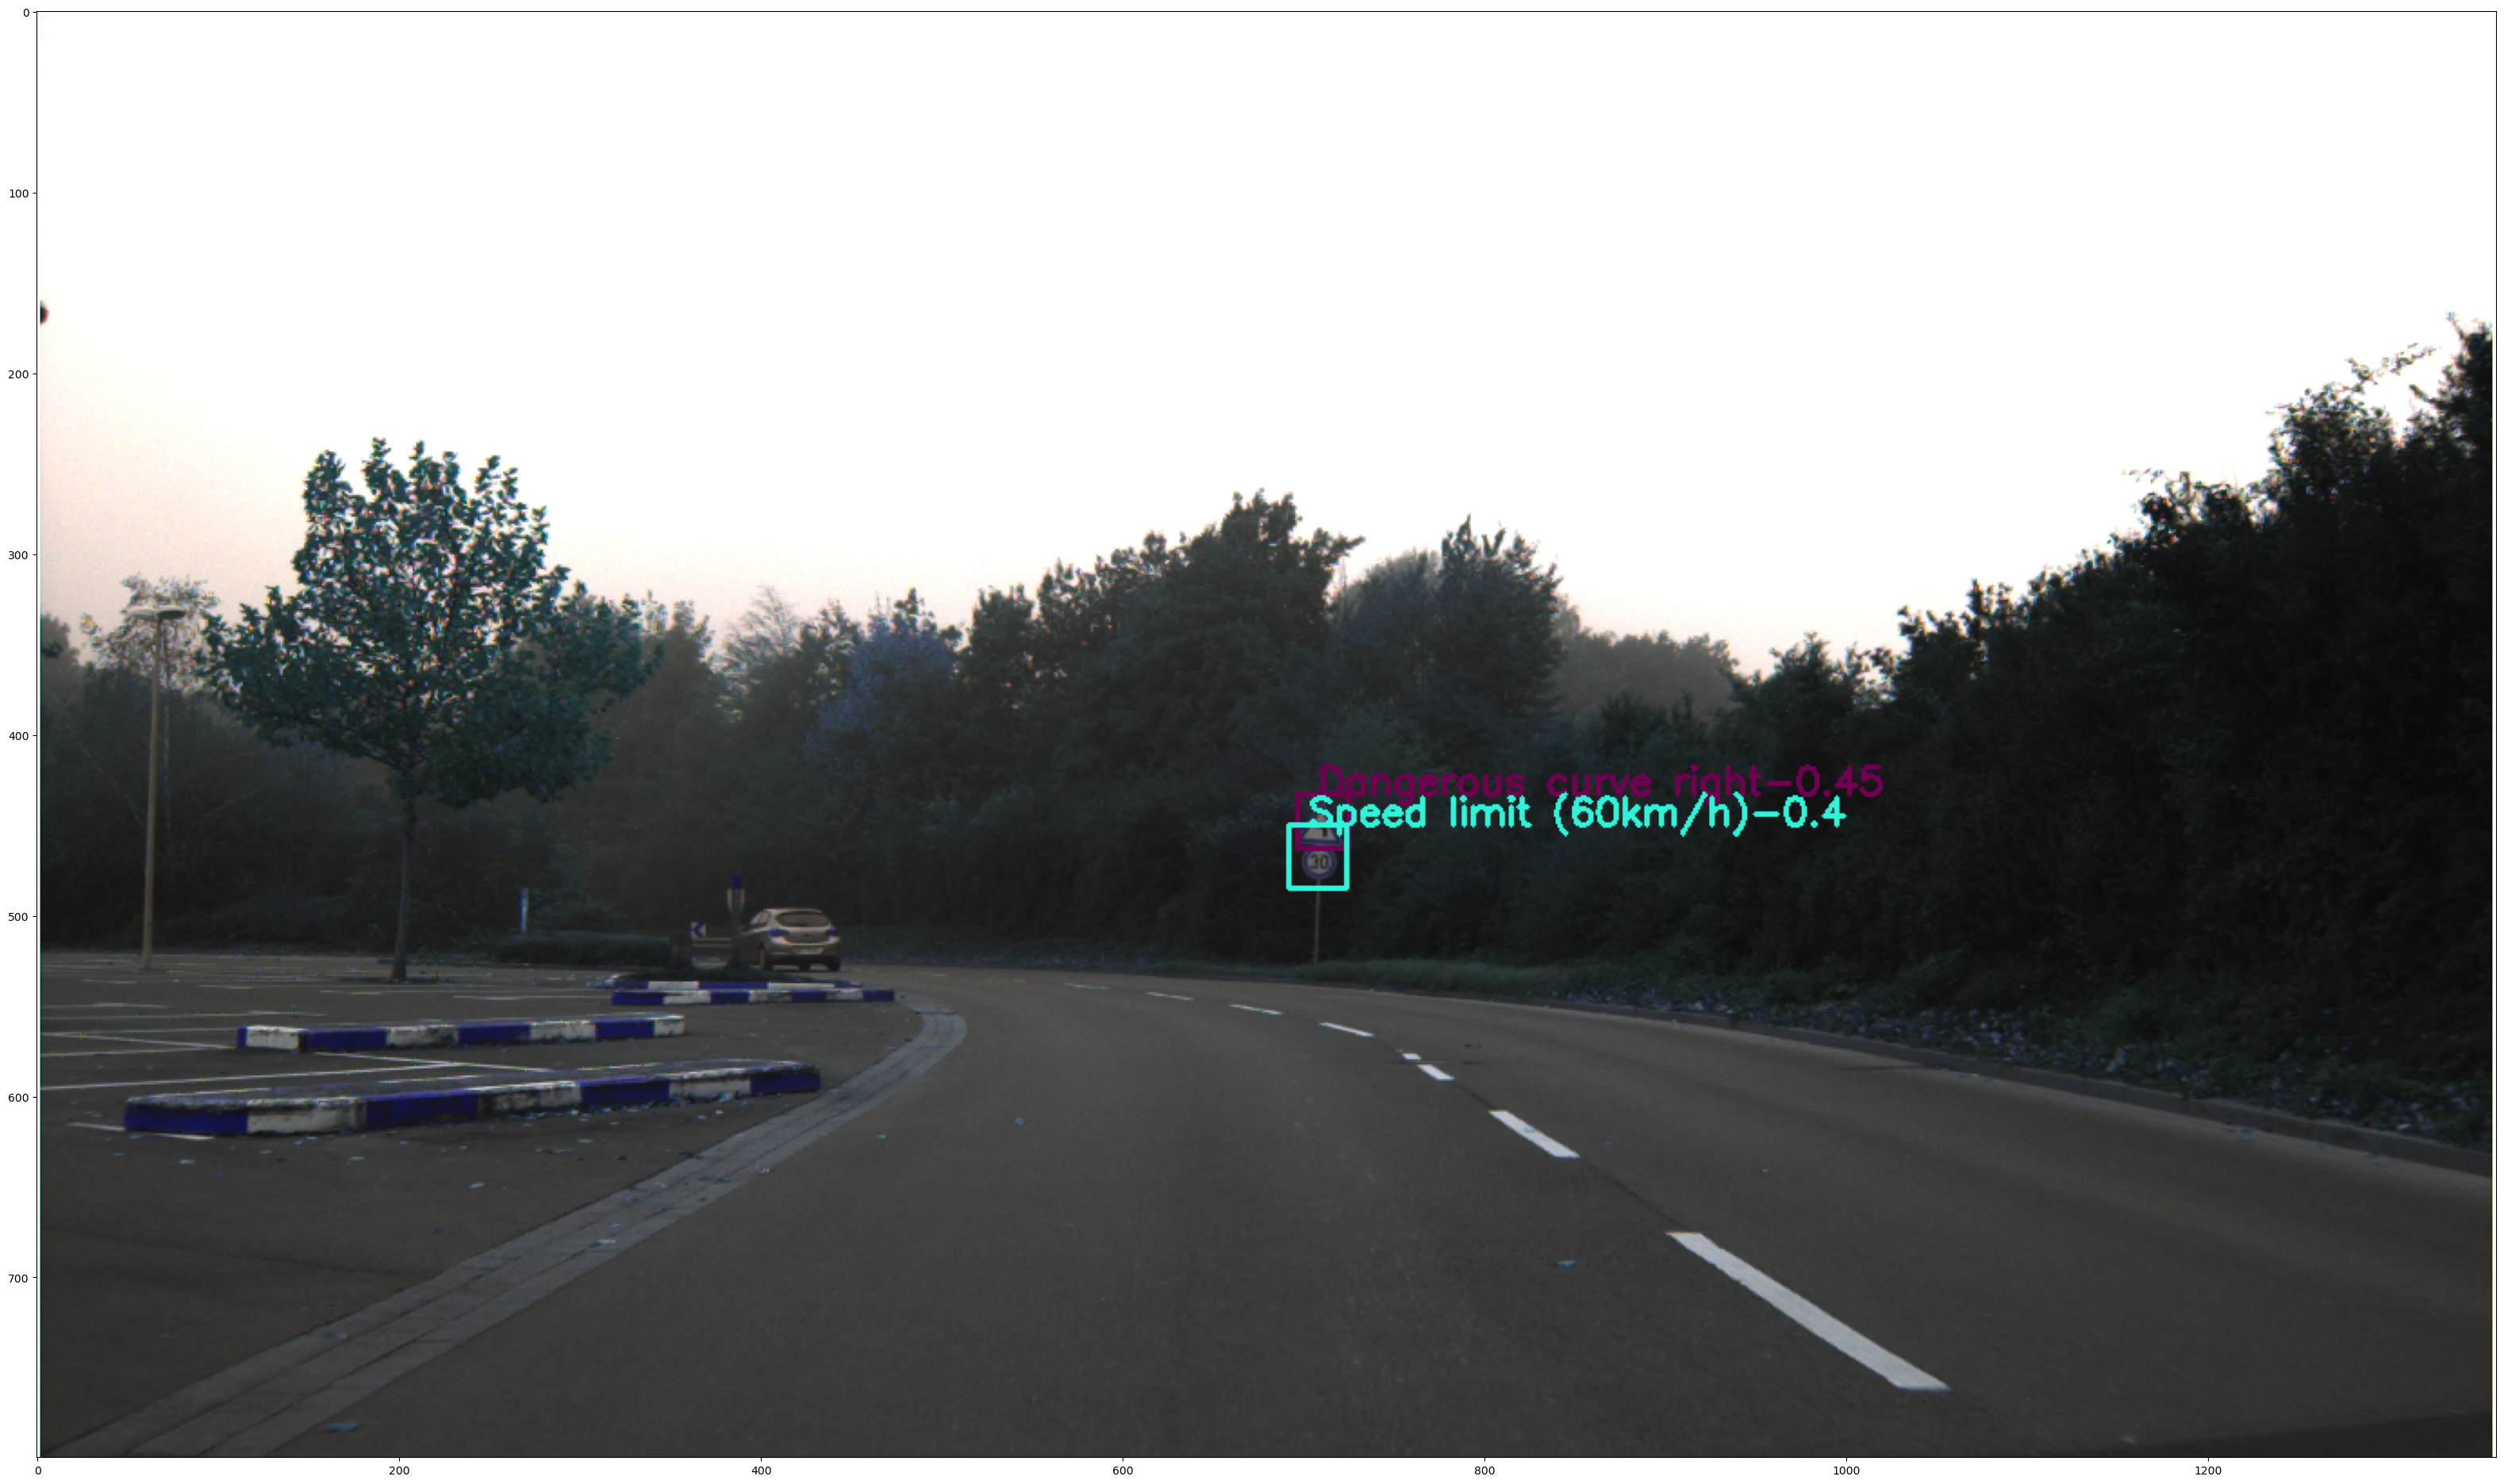

In [68]:
#Test the model:
img, _ = dataset_test[2]
showbbox(model, img)

#### Displaying the original image

To check the difference between processed image and original image.

It can be observed that using ImageNet's mean and standard deviation values, normalization was performed by default in Faster RCNN.

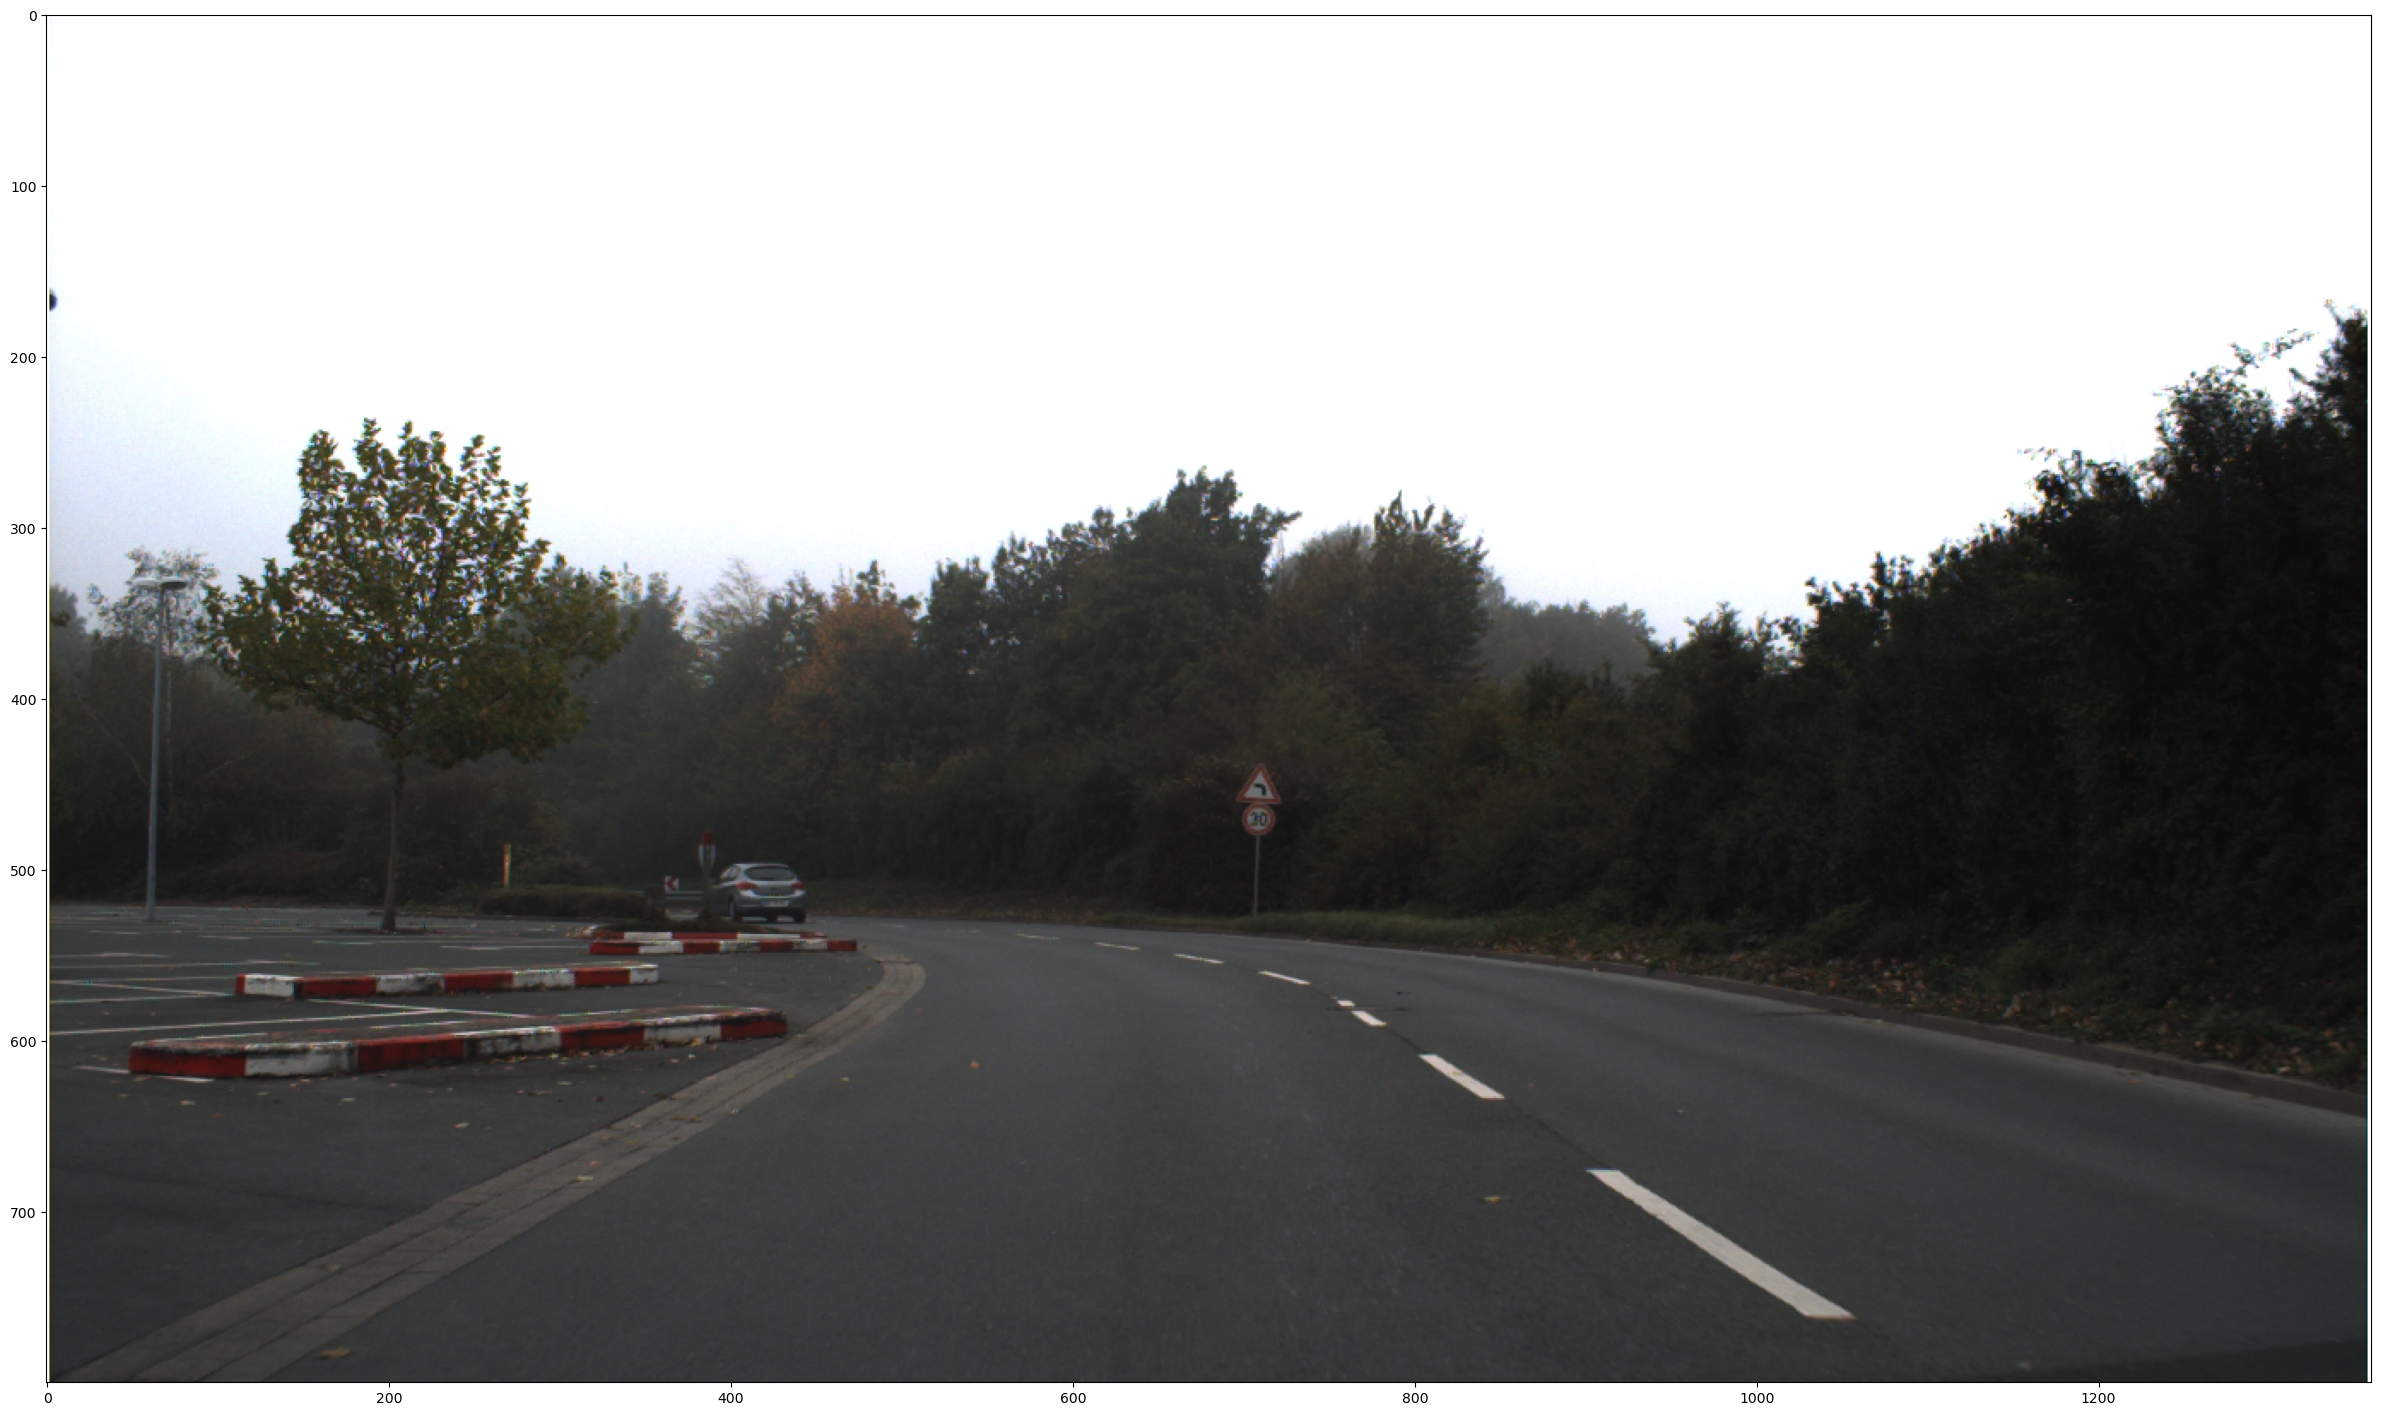

In [69]:
#Show original image:
img = img.permute(1,2,0)  # C,H,W_H,W,C, for drawing
img = (img * 255).byte().data.cpu()  # * 255, float to 0-255
img = np.array(img)  # tensor → ndarray
plt.figure(figsize=(30,30))
plt.imshow(img)